In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz
import pickle

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree

C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
df_Nacional = pd.read_csv('../microdadosEnem_Nacional_Amostragem.csv', sep = ';', encoding='ISO 8859-1')
df_Nacional = df_Nacional.loc[:, ~df_Nacional.columns.str.contains('^Unnamed')]
df_Alagoas = pd.read_csv('../microdadosEnemAlagoas.csv', sep = ';', encoding='ISO 8859-1')
df_Alagoas = df_Alagoas.loc[:, ~df_Alagoas.columns.str.contains('^Unnamed')]

In [5]:
df_dicionario = pd.read_csv('../dicionário reduzido.csv', sep = ',')
df_dicionario

,DICIONÁRIO DE VARIÁVEIS - ENEM 2018 - (Modificado),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NOME DA VARIÁVEL,Descrição,Variáveis Categóricas,NaN,Tipo
2,NaN,NaN,Categoria,Descrição,NaN
3,DADOS DO PARTICIPANTE,NaN,NaN,NaN,NaN
4,NU_INSCRICAO,Número de inscrição1,NaN,NaN,Numérica
...,...,...,...,...,...
204,7. A opção de certificação só é apresentada pa...,NaN,NaN,NaN,NaN
205,8. As 45 primeiras posições deste campo são re...,NaN,NaN,NaN,NaN
206,9. As 45 primeiras posições deste campo são re...,NaN,NaN,NaN,NaN
207,10. As 45 primeiras posições deste campo são r...,NaN,NaN,NaN,NaN


In [4]:
# feature-cols vai armazenar todas as colunas exceto a coluna que armazena as
# notas de matemática do participante de Alagoas
feature_cols = [x for x in df_Alagoas.columns if x != 'NU_NOTA_MT']
X = df_Alagoas[feature_cols]
Y = df_Alagoas['NU_NOTA_MT']
X2= df_Nacional[feature_cols]
Y2 = df_Nacional['NU_NOTA_MT']


In [14]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split( X2, Y2, test_size=0.3, random_state=0)
#test-size = 0.3 define que o tamanho da base de teste é de 30% da base principal, e a base de treino é 70%

#visualizando os tamanhos da bases, teino e teste
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


In [2]:
numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',  'Q005']
categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

In [3]:
feature_names= numeric_features + categorical_features
len(feature_names)
print(feature_names)

['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q005', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']


In [6]:
rf    = pickle.load(open('RandomForest_AL.sav', 'rb'))
rf2    = pickle.load(open('RandomForest_BR.sav', 'rb'))


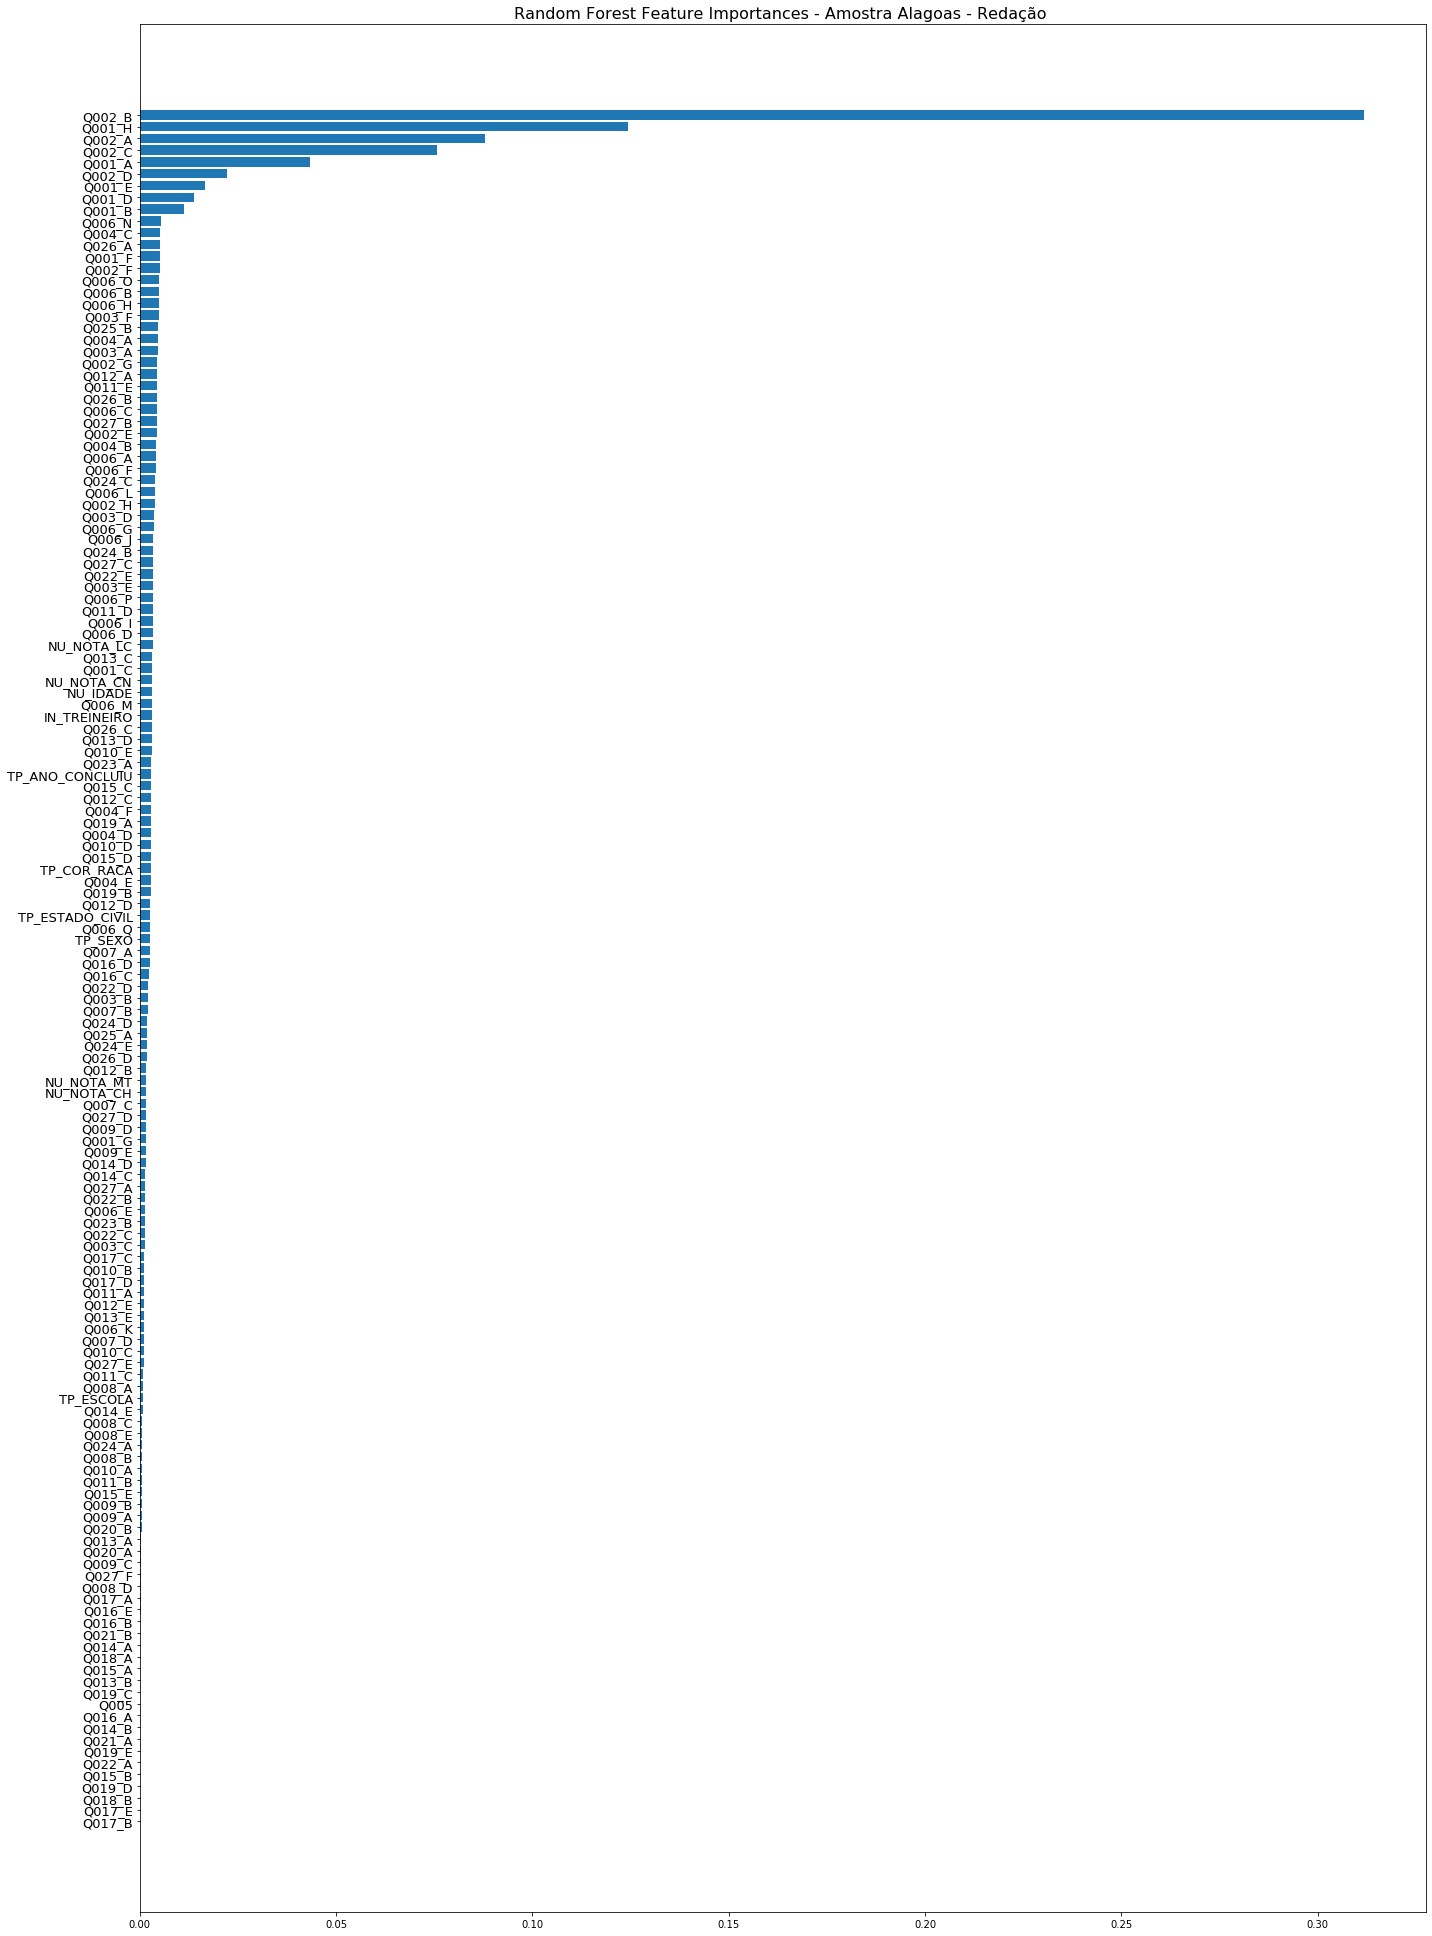

In [10]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances - Amostra Alagoas - Redação ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_AL_MT.png', format='png')
plt.show()

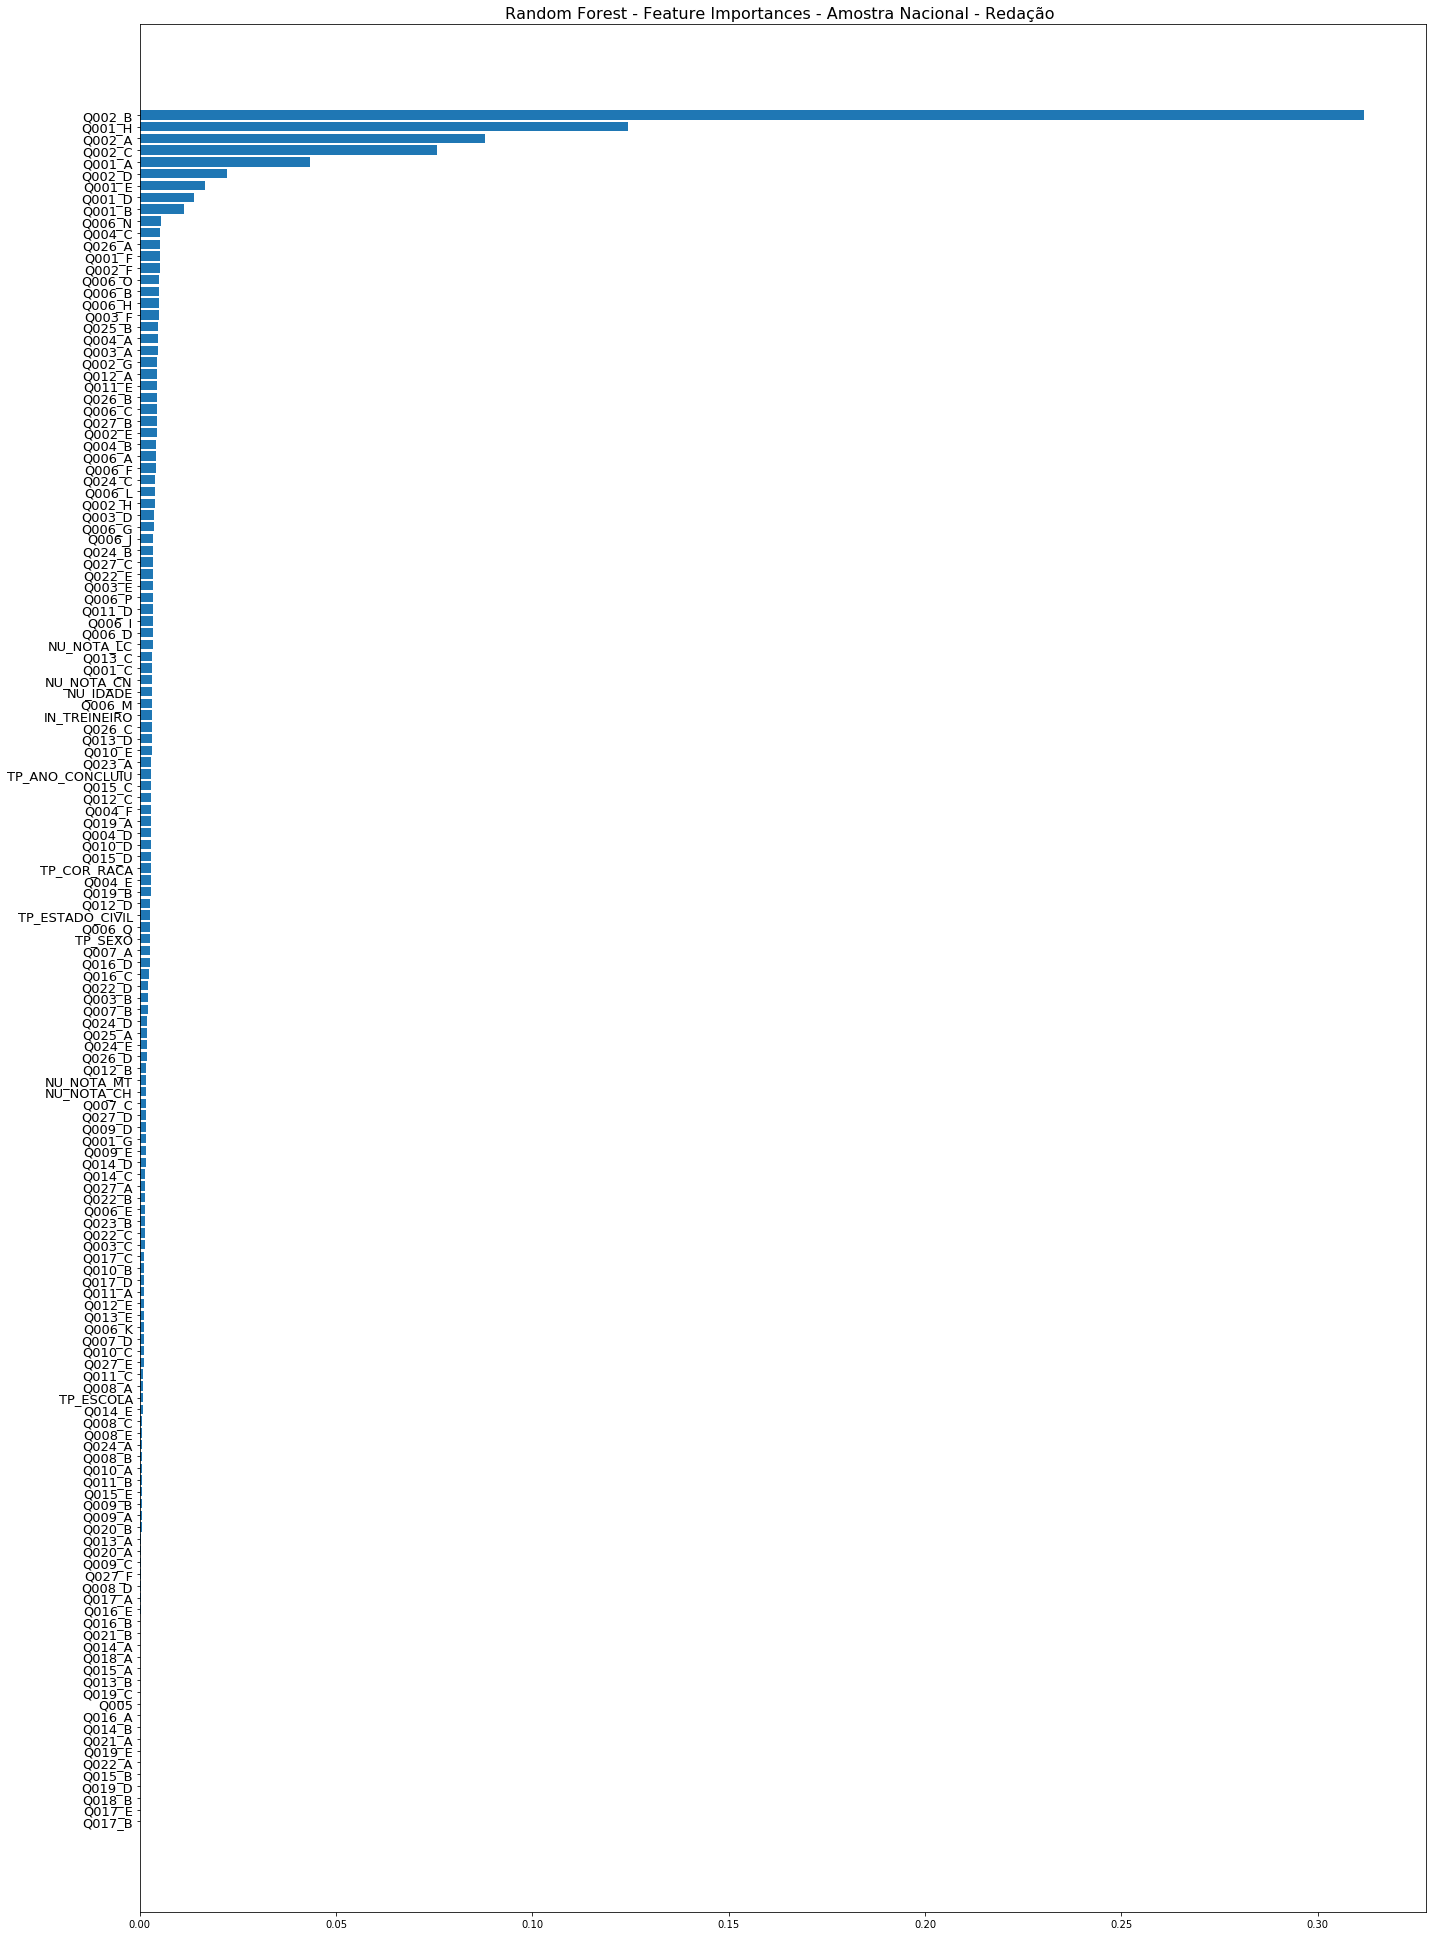

In [14]:
ohe = (rf2.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf2.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest - Feature Importances - Amostra Nacional - Redação ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesRF_BR_MT.png', format='png')
plt.show()

In [5]:
dtree = pickle.load(open('ArvoreDeDecisao_AL.sav', 'rb'))
dtree2 = pickle.load(open('ArvoreDeDecisao_BR.sav', 'rb'))

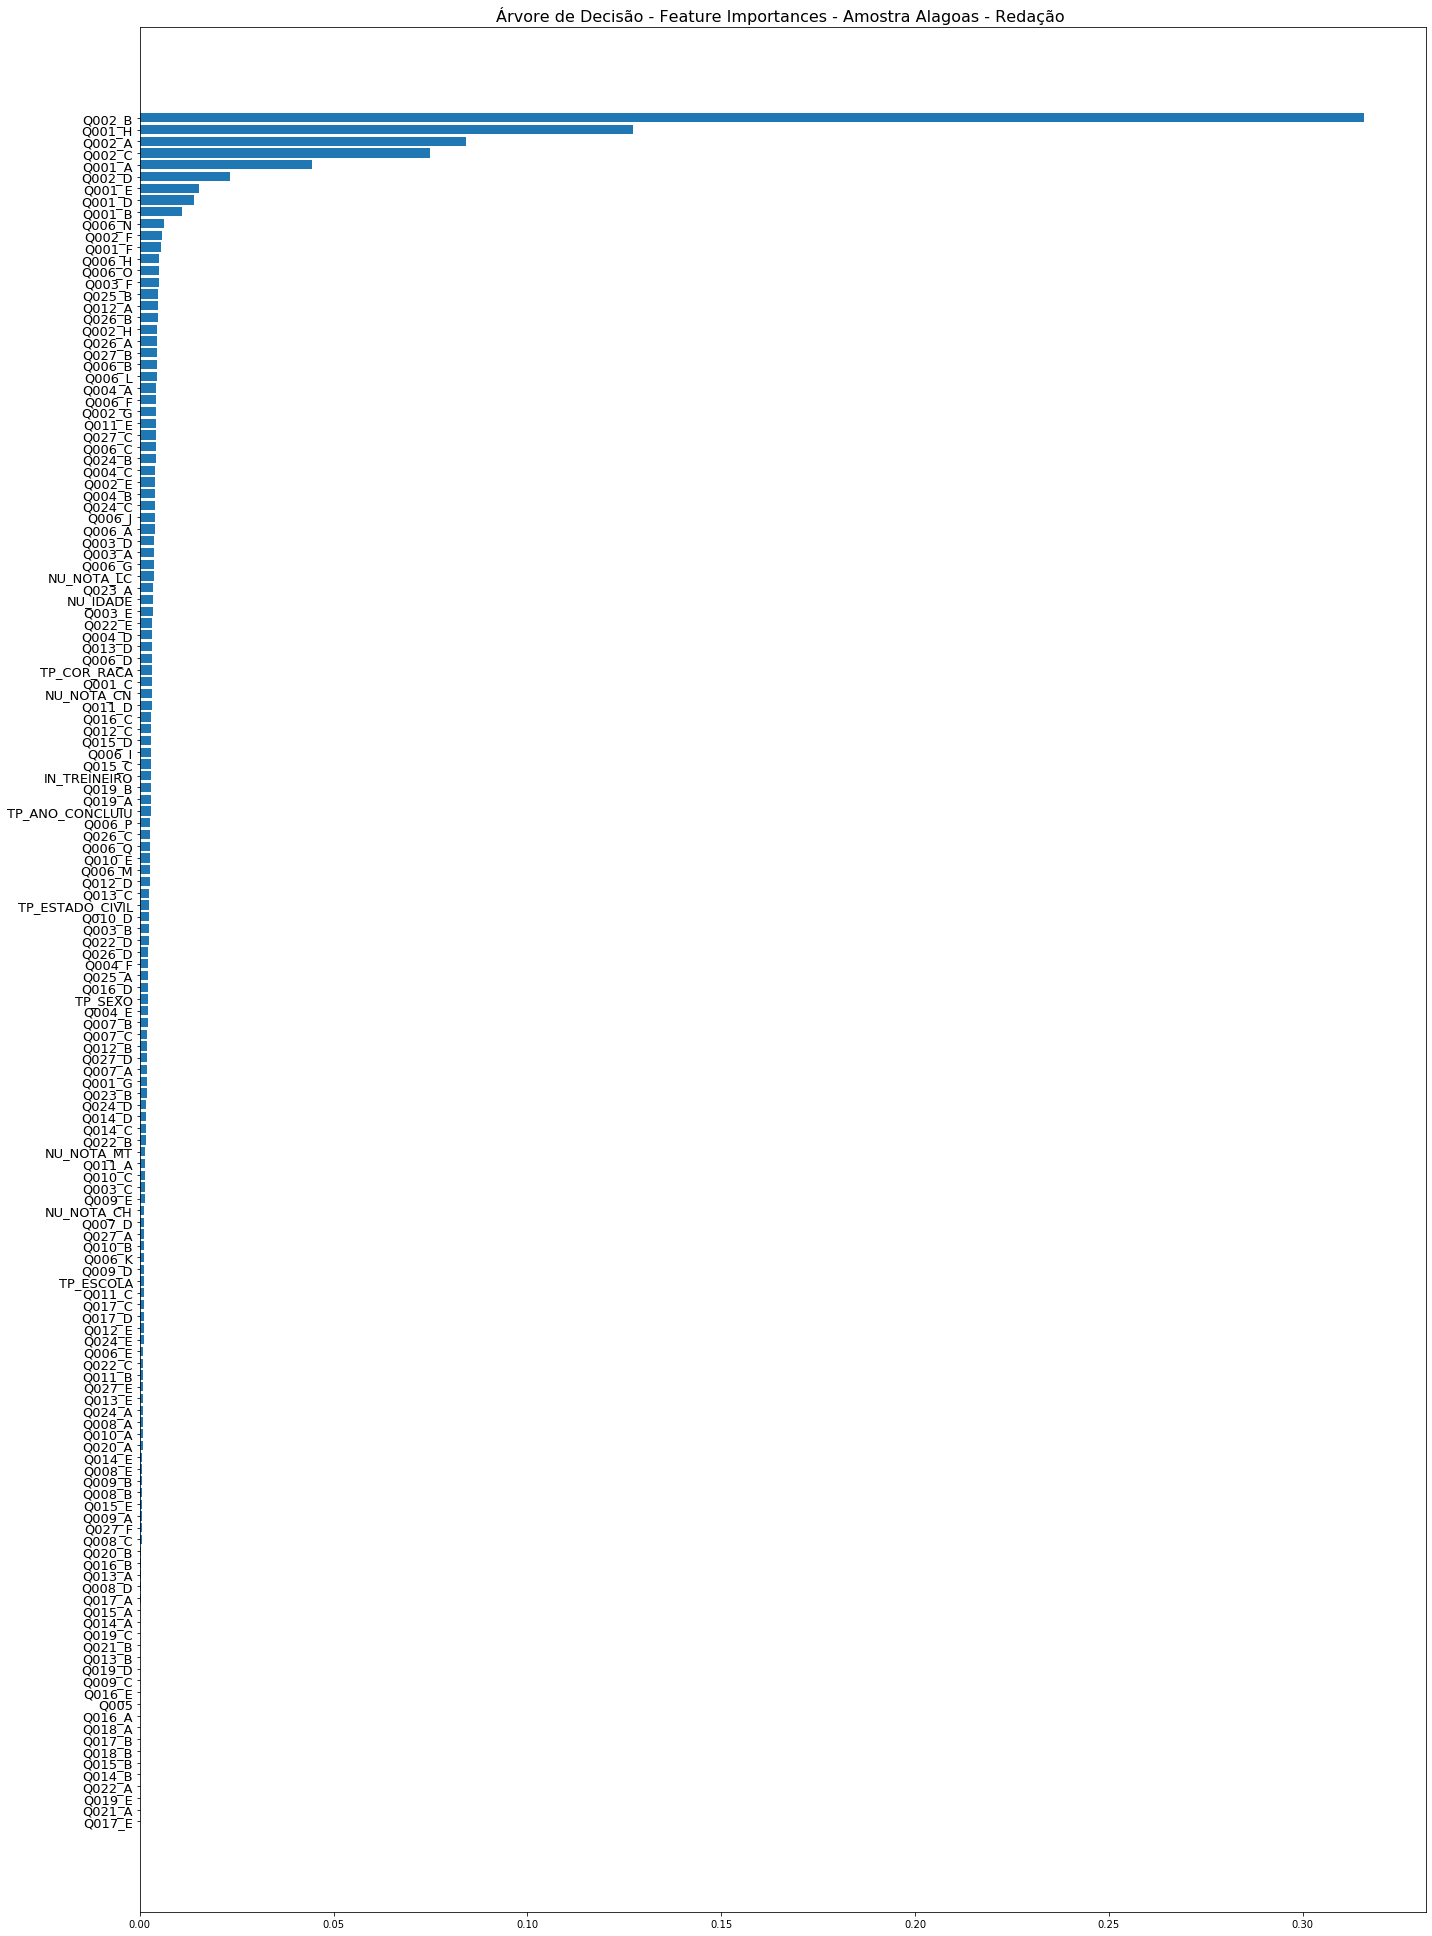

In [29]:
ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Árvore de Decisão - Feature Importances - Amostra Alagoas - Redação ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_AL_RD.png', format='png')
plt.show()

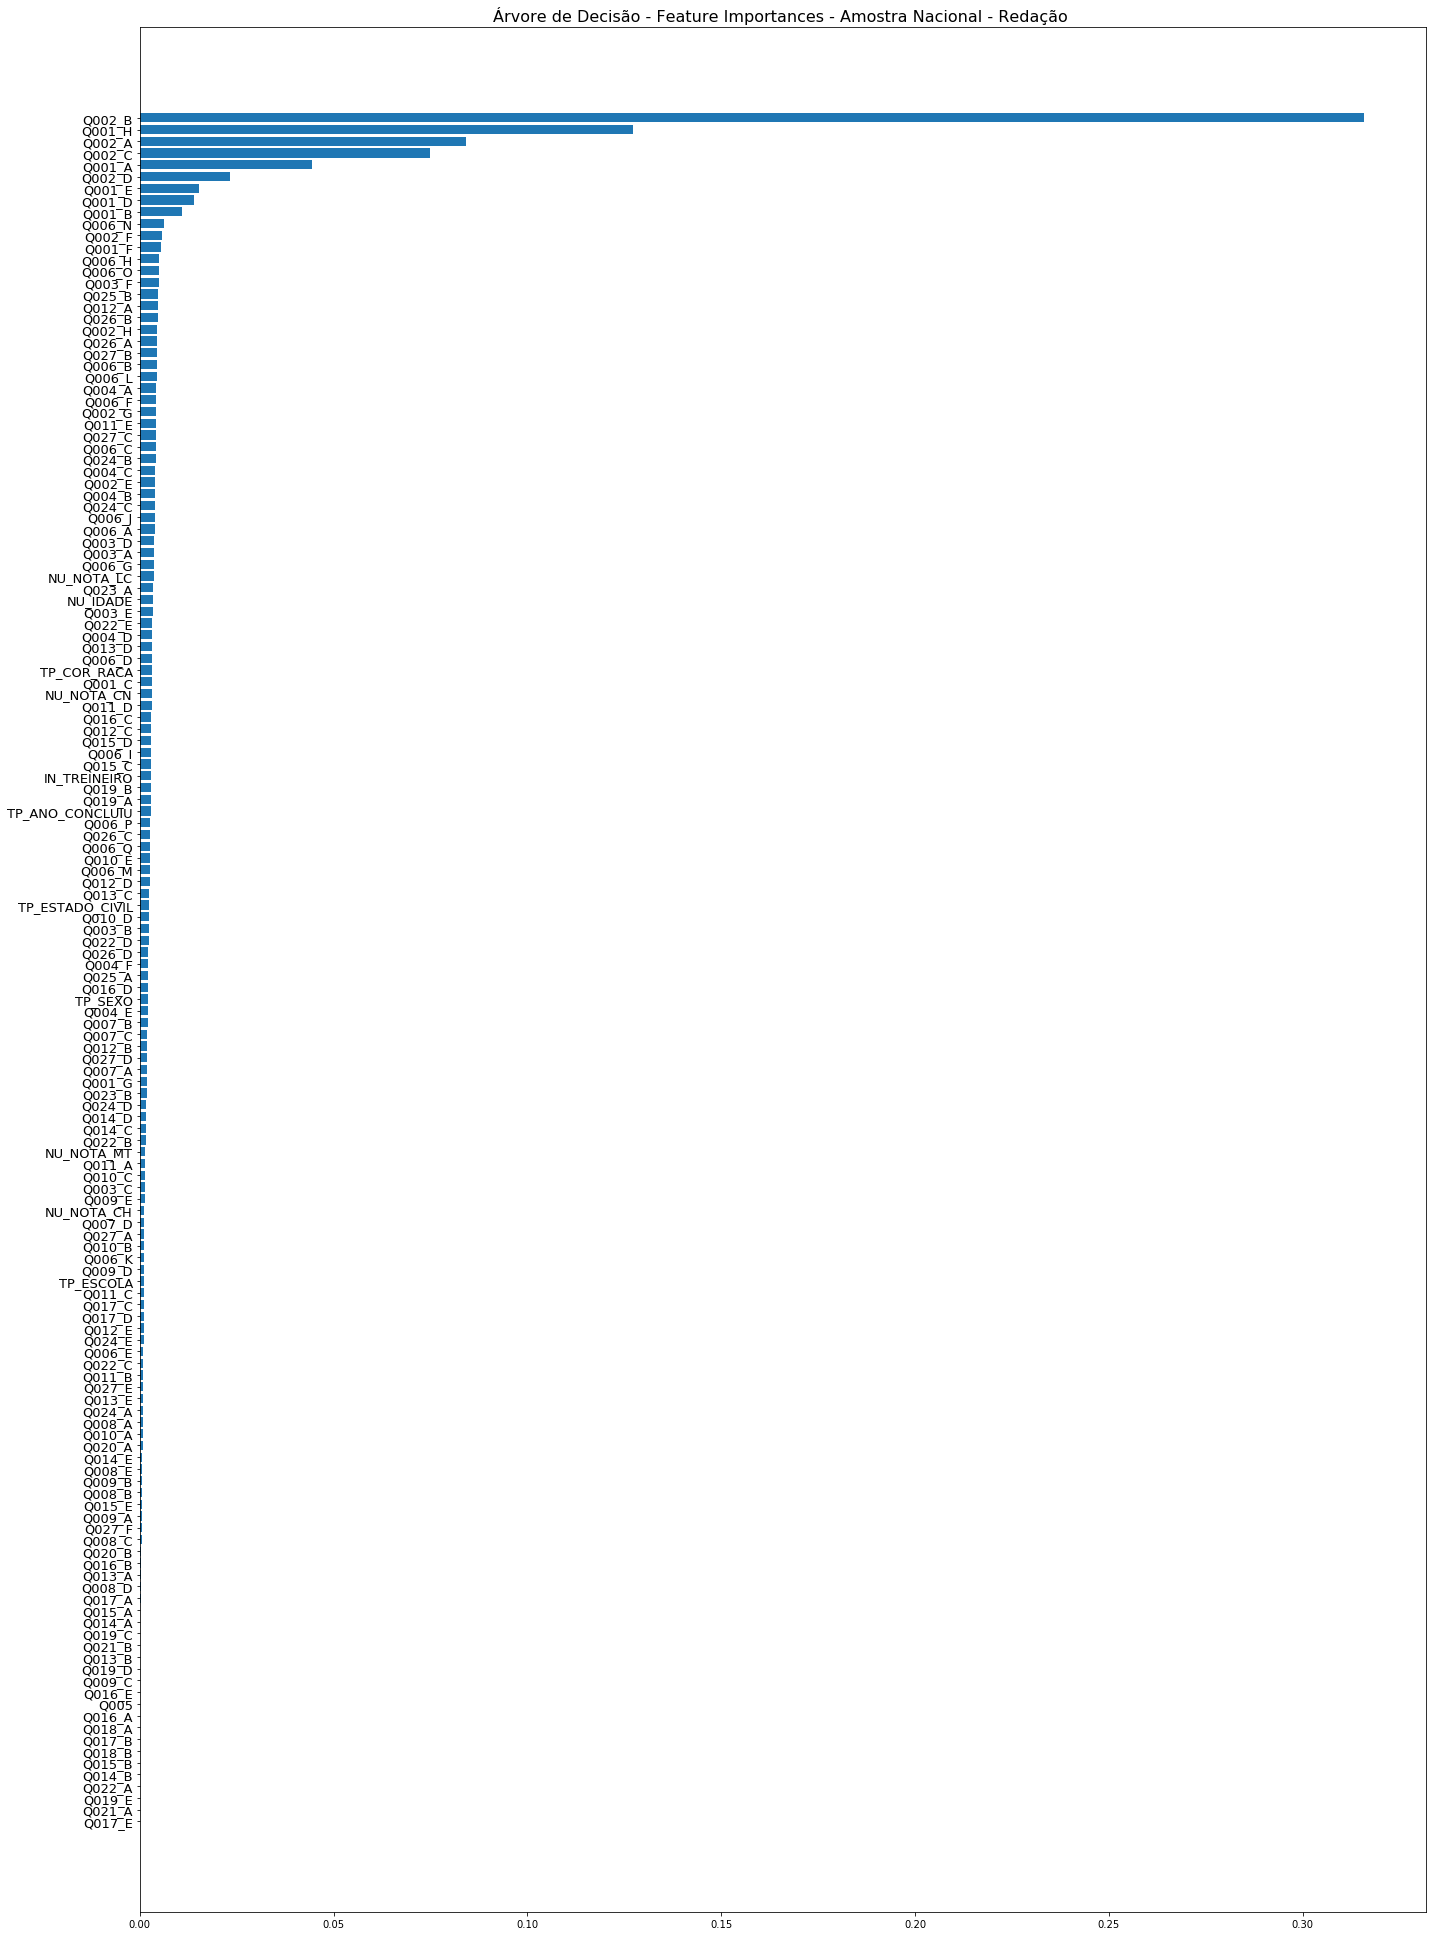

In [30]:
ohe = (dtree2.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree2.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 27))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx], fontsize = 13)
ax.set_yticks(y_ticks)
ax.set_title("Árvore de Decisão - Feature Importances - Amostra Nacional - Redação ", fontsize = 16)
fig.tight_layout()
plt.savefig('imagens/featuresImportancesDT_BR_RD.png', format='png')
plt.show()

In [ ]:
Q002_A
Q001_H
Q002_B
Q002_C
Q001_A
Q001_B
Q002_D
Q001_E
Q006_N
Q003_A
Q025_B
Q006_H


Os resultados das importâncias das features para o modelo Árvore de decisão foram iguais, tanto para base nacional quanto para base de alagoas, as 10 features mais importantes foram classficadas nas mesmas posições e com as mesma porcetagens.
Para esse modelo as features que tiveram maior importância foram as que tratavam da seguinte pergunta:

Q001:
Alternativas:
A:
B:
C:
D:
E:

Q002:
A
B
C
D

Q006:
N:
H:

Q003:
A:

Q025:
B


In [7]:
df_RF = pd.DataFrame()
df_DT = pd.DataFrame()

In [8]:

ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (rf.named_steps['regressor'].feature_importances_)
tree_feature_importances2 = (rf2.named_steps['regressor'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()
sorted_idx2 = tree_feature_importances2.argsort()

features_importance = zip(tree_feature_importances, feature_names)
features_importance2 = zip(tree_feature_importances2, feature_names)


print()
labels = []
importances = []
l2 = []
i=[]
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
for importance, feature, in sorted(features_importance2, reverse=True):
    
    x = round(importance*100, 2)
    l2.append(feature)
    i.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
    

df_RF['importances RF AL'] = importances
df_RF['features'] = labels
df_RF['importances RF NA'] = i
df_RF['features'] = l2


print(importances)


Q002_B: 31.186335%
Q001_H: 12.438091%
Q002_A: 8.787949%
Q002_C: 7.556954%
Q001_A: 4.346309%
Q002_D: 2.216675%
Q001_E: 1.664217%
Q001_D: 1.372370%
Q001_B: 1.127469%
Q006_N: 0.532358%
Q004_C: 0.526371%
Q026_A: 0.520021%
Q001_F: 0.518179%
Q002_F: 0.513631%
Q006_O: 0.493764%
Q006_B: 0.493296%
Q006_H: 0.492900%
Q003_F: 0.480291%
Q025_B: 0.464323%
Q004_A: 0.457727%
Q003_A: 0.453406%
Q002_G: 0.450107%
Q012_A: 0.445590%
Q011_E: 0.444106%
Q026_B: 0.438230%
Q006_C: 0.430899%
Q027_B: 0.429809%
Q002_E: 0.427311%
Q004_B: 0.412733%
Q006_A: 0.404242%
Q006_F: 0.402338%
Q024_C: 0.376956%
Q006_L: 0.375726%
Q002_H: 0.375523%
Q003_D: 0.368572%
Q006_G: 0.363767%
Q006_J: 0.344776%
Q024_B: 0.344192%
Q027_C: 0.340215%
Q022_E: 0.339187%
Q003_E: 0.338616%
Q006_P: 0.334648%
Q011_D: 0.327362%
Q006_I: 0.326928%
Q006_D: 0.325974%
NU_NOTA_LC: 0.323811%
Q013_C: 0.321982%
Q001_C: 0.320870%
NU_NOTA_CN: 0.319616%
NU_IDADE: 0.311244%
Q006_M: 0.310937%
IN_TREINEIRO: 0.309855%
Q026_C: 0.305030%
Q013_D: 0.302259%
Q010_E: 0

In [9]:

ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)
tree_feature_importances2 = (dtree.named_steps['regressor'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()
sorted_idx2 = tree_feature_importances2.argsort()

features_importance = zip(tree_feature_importances, feature_names)
features_importance2 = zip(tree_feature_importances2, feature_names)


print()
labels = []
importances = []
l2 = []
i=[]
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
for importance, feature, in sorted(features_importance2, reverse=True):
    
    x = round(importance*100, 2)
    l2.append(feature)
    i.append(x)    
    print("%s: %f%%" % (feature, importance*100)) 
    

df_RF['importances DT AL'] = importances
df_RF['features'] = labels
df_RF['importances DT NA'] = i
df_RF['features'] = l2


print(importances)


Q002_B: 31.594885%
Q001_H: 12.725529%
Q002_A: 8.410356%
Q002_C: 7.492384%
Q001_A: 4.449815%
Q002_D: 2.334634%
Q001_E: 1.528564%
Q001_D: 1.385583%
Q001_B: 1.100051%
Q006_N: 0.612228%
Q002_F: 0.569679%
Q001_F: 0.538789%
Q006_H: 0.498552%
Q006_O: 0.497388%
Q003_F: 0.494750%
Q025_B: 0.474657%
Q012_A: 0.464603%
Q026_B: 0.461844%
Q002_H: 0.448345%
Q026_A: 0.439660%
Q027_B: 0.438662%
Q006_B: 0.435098%
Q006_L: 0.434850%
Q004_A: 0.427079%
Q006_F: 0.421440%
Q002_G: 0.420123%
Q011_E: 0.417670%
Q027_C: 0.416362%
Q006_C: 0.410817%
Q024_B: 0.410290%
Q004_C: 0.404157%
Q002_E: 0.402580%
Q004_B: 0.401235%
Q024_C: 0.396316%
Q006_J: 0.392790%
Q006_A: 0.389709%
Q003_D: 0.377640%
Q003_A: 0.363262%
Q006_G: 0.361493%
NU_NOTA_LC: 0.360904%
Q023_A: 0.343343%
NU_IDADE: 0.337840%
Q003_E: 0.330188%
Q022_E: 0.325802%
Q004_D: 0.323561%
Q013_D: 0.321830%
Q006_D: 0.319294%
TP_COR_RACA: 0.317312%
Q001_C: 0.316360%
NU_NOTA_CN: 0.307138%
Q011_D: 0.301603%
Q016_C: 0.300106%
Q012_C: 0.295667%
Q015_D: 0.292115%
Q006_I: 0.

In [30]:
df1 = pd.DataFrame()
df1 = df_RF.loc[(df_RF['importances RF AL'] <= 1)]

x1 = df1['importances RF AL'].sum()
x1
df1
print (x1)

29.28


In [47]:
df2 = pd.DataFrame()
df2 = df_RF.loc[(df_RF['importances RF AL'] >= 1)]

x2 = df2['importances RF AL'].sum()
x2
df2

,importances RF AL,features,importances RF NA
0,31.19,Q002_B,31.19
1,12.44,Q001_H,12.44
2,8.79,Q002_A,8.79
3,7.56,Q002_C,7.56
4,4.35,Q001_A,4.35
5,2.22,Q002_D,2.22
6,1.66,Q001_E,1.66
7,1.37,Q001_D,1.37
8,1.13,Q001_B,1.13


In [48]:
df3 = pd.DataFrame()
df3=df2
#df3['features'] = "Outros"
df2



,importances RF AL,features,importances RF NA
0,31.19,Q002_B,31.19
1,12.44,Q001_H,12.44
2,8.79,Q002_A,8.79
3,7.56,Q002_C,7.56
4,4.35,Q001_A,4.35
5,2.22,Q002_D,2.22
6,1.66,Q001_E,1.66
7,1.37,Q001_D,1.37
8,1.13,Q001_B,1.13


In [49]:
df4 = pd.DataFrame()
df4['importances RF AL'] = [x1]
df4['features'] =[ "Outros"]
df4

,importances RF AL,features
0,29.28,Outros


In [50]:
df3 = pd.concat([df2, df4])
x1
df3

,importances RF AL,features,importances RF NA
0,31.19,Q002_B,31.19
1,12.44,Q001_H,12.44
2,8.79,Q002_A,8.79
3,7.56,Q002_C,7.56
4,4.35,Q001_A,4.35
5,2.22,Q002_D,2.22
6,1.66,Q001_E,1.66
7,1.37,Q001_D,1.37
8,1.13,Q001_B,1.13
0,29.28,Outros,NaN


In [35]:
100-x1
df3['importances RF AL'] = x1

df3

C:\Users\aleon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,importances RF AL,features,importances RF NA
0,29.28,Q002_B,31.19
1,29.28,Q001_H,12.44
2,29.28,Q002_A,8.79
3,29.28,Q002_C,7.56
4,29.28,Q001_A,4.35
5,29.28,Q002_D,2.22
6,29.28,Q001_E,1.66
7,29.28,Q001_D,1.37
8,29.28,Q001_B,1.13


In [67]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 0
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   importances RF AL  10 non-null     float64
 1   features           10 non-null     object 
 2   importances RF NA  9 non-null      float64
dtypes: float64(2), object(1)
memory usage: 320.0+ bytes


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA7CE62278>],
      dtype=object)

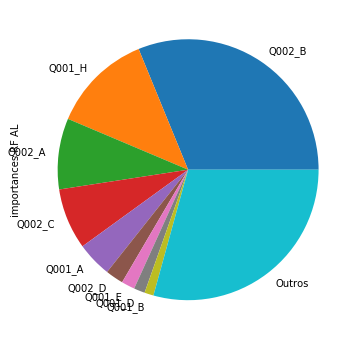

In [69]:
df_RF
df = pd.DataFrame()
df = df_RF.loc[(df_RF['importances RF AL'] >= 2)]
#df['importances RF AL'].plot.pie(subplots = True, autopct='%1.1f%%', colors = ["#20257c", "#424ad1", "#6a8ee8", "#66bbe2", "#66dee2", "#6ce2cb", "#6ad187", "#3b7f5b"],
        #labeldistance = 1.1,)
df['importances RF AL']
#x = df['importances RF AL']
x= df3['importances RF AL']
x.plot.pie(subplots=True,labels=df3['features'], figsize=(6, 6),)

In [133]:
pip install palettable

Note: you may need to restart the kernel to use updated packages.


In [70]:
c=[plt.cm.Blues]
s = np.arange(0.1, 1, 0.1)
colors=[]
from palettable.colorbrewer.qualitative import Pastel1_7
from palettable.matplotlib import Magma_9, Inferno_9
from palettable.cmocean.diverging import Balance_9, Delta_9
from palettable.colorbrewer.qualitative import Paired_9
from palettable.scientific.diverging import Cork_9, Roma_10


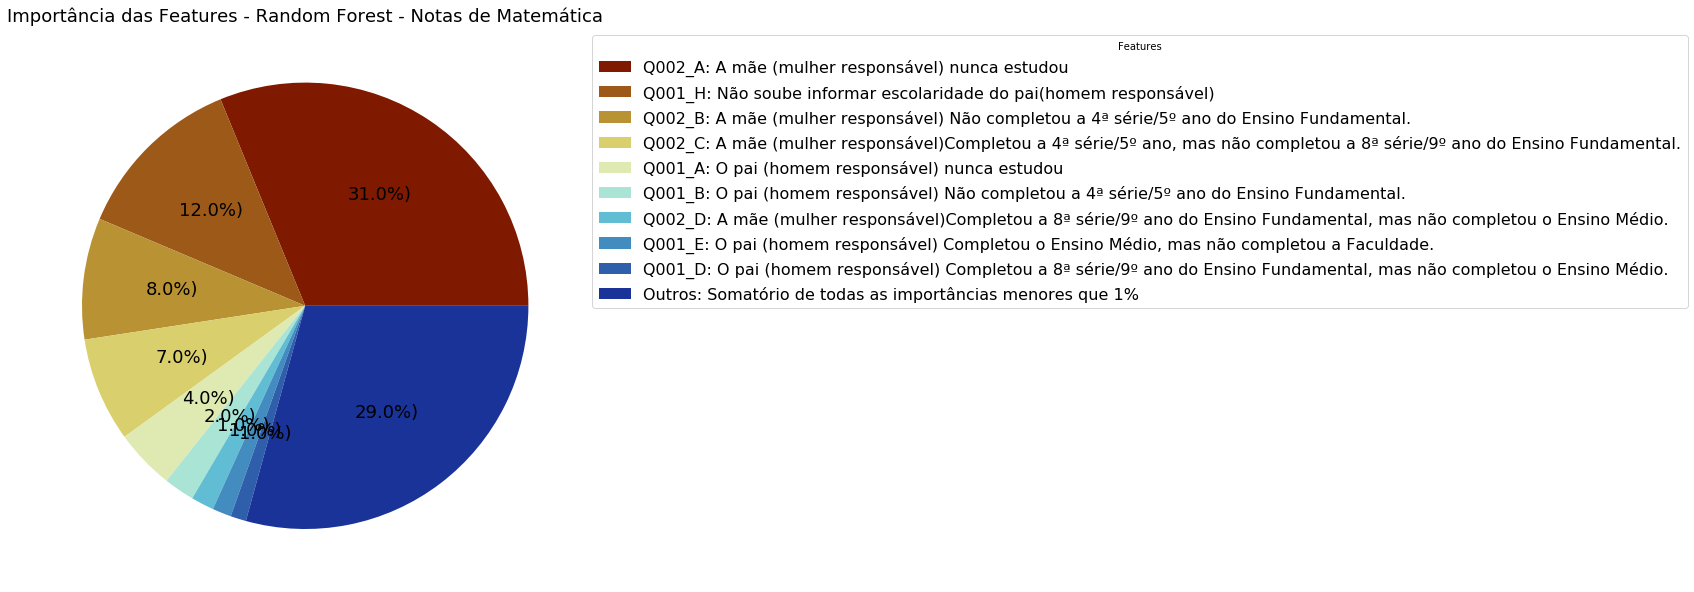

In [71]:
fig, ax = plt.subplots(figsize=(10, 12), subplot_kw=dict(aspect="equal"))
x= df3['importances RF AL']
recipe = x
c=[plt.cm.Blues]
s = range(2, 10, 2)

data = x
#ingredients = df['features']
ingredients = ['Q002_A: A mãe (mulher responsável) nunca estudou' ,
               'Q001_H: Não soube informar escolaridade do pai(homem responsável)',
               'Q002_B: A mãe (mulher responsável) Não completou a 4ª série/5º ano do Ensino Fundamental.',
               'Q002_C: A mãe (mulher responsável)Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.',
               'Q001_A: O pai (homem responsável) nunca estudou',
               'Q001_B: O pai (homem responsável) Não completou a 4ª série/5º ano do Ensino Fundamental.',
               'Q002_D: A mãe (mulher responsável)Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.',
               'Q001_E: O pai (homem responsável) Completou o Ensino Médio, mas não completou a Faculdade.',
               'Q001_D: O pai (homem responsável) Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.',
               'Outros: Somatório de todas as importâncias menores que 1%' ,              
              ]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%)".format(absolute, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"), colors= Roma_10.hex_colors)

ax.legend(wedges, ingredients,
          title="Features",loc="best", fontsize = 16,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=18)

ax.set_title("Importância das Features - Random Forest - Notas de Matemática", fontsize = 18)
plt.savefig('imagens/pieFI_RF_BR.png', format='png')
plt.show()

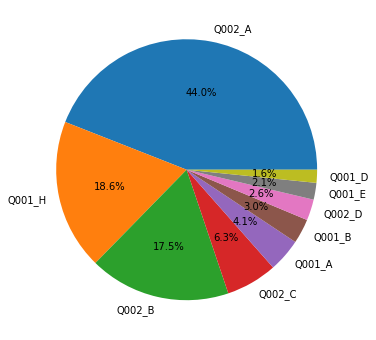

In [44]:

explode= [0.1, 0.1, 0.1, 0.1, 0,0,0,0,0]

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(df['importances RF AL'], labels=df['features'], autopct='%1.1f%%')
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [7]:
df_RF["Questão"] = [s.split("_")[0] for s in df_RF.features]
df_RF["Alternativa"]=[s.split("_")[1] for s in df_RF.features]
s = "hello, world!"
s = "Q014_D"
print(s.split("_"))

['Q014', 'D']


In [29]:

ohe = (dtree.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]

tree_feature_importances = (dtree.named_steps['regressor'].feature_importances_)

sorted_idx = tree_feature_importances.argsort()

features_importance = zip(tree_feature_importances, feature_names)

print()
labels = []
importances = []
for importance, feature, in sorted(features_importance, reverse=True):
    
    x = round(importance*100, 2)
    labels.append(feature)
    importances.append(x)    
    print("%s: %f%%" % (feature, importance*100))  

df_DT['importances DT'] = importances
df_DT['features'] = labels

print(importances, labels)

NameError: name 'dtree' is not defined

In [28]:
df.sample(100).plot.bar(stacked=True, figsize=(20,10));

NameError: name 'df' is not defined

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
ratios = [.33, .54, .07, .06]
width = .2
colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Age of approvers')
ax2.legend(('50-65', 'Over 65', '35-49', 'Under 35'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()